In [1]:
import cv2 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import timm
from torch.utils.tensorboard import SummaryWriter
from PIL import Image

In [9]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.model = timm.create_model("tf_efficientnet_b4_ns",pretrained=True) 
        self.model.classifier = nn.Sequential(
            nn.Linear(in_features=1792, out_features=1024, bias=True),
            nn.ReLU(),
            nn.Dropout(p=0.3, inplace=False),
            nn.Linear(in_features=1024, out_features=512, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=256, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=7, bias=True))
        
        self.FILE = "model.pth"
        self.in_size = (3,224,224)
    def save_model(self):
        torch.save(model.state_dict(), FILE)   
    def load_model(self):
        self.model.load_state_dict(torch.load(FILE))
    def train_mode(self):
        self.model.train()
        for param in self.model.parameters():
            param.requires_grad = True
    def eval_mode(self):
        self.model.eval()
        for param in self.model.parameters():
            param.requires_grad = False
    def forward(self,x):
        return self.model(x)
    def load_dict(self,dic):
        self.model.load_state_dict(dic,strict=False)
x = torch.load("0.95 ac.pth")

In [18]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

transforms_c= transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)]
    )
img = cv2.imread("./data/train/a.png")
pil_img = Image.fromarray(img[:,:,[2,1,0]])
transformed_img = transforms_c(pil_img)
transformed_img = transformed_img.view((1,3,224,224))


In [19]:
x.eval()
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class_names = ['Andezit', 'Basalt', 'Diyorit', 'Granit', 'Riyolit', 'Siyenit', 'Trakit']
with torch.no_grad():
    x = x.to("cuda")
    transformed_img = transformed_img.to("cuda")
    outputs = x(transformed_img)
    possibilities = torch.exp(outputs) / torch.exp(outputs).sum()
    vals,indices = torch.topk(possibilities,3)
    print(vals,indices)
    for i in range(3):
       print(class_names[indices[0,i].item()] + ": " + str(vals[0,i].item()))

tensor([[0.4543, 0.2877, 0.0785]], device='cuda:0') tensor([[5, 3, 2]], device='cuda:0')
Siyenit: 0.4543195068836212
Granit: 0.28772982954978943
Diyorit: 0.07845388352870941


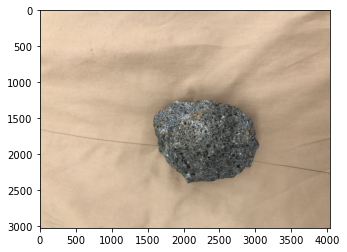

In [112]:
plt.imshow(img[:,:,[2,1,0]])

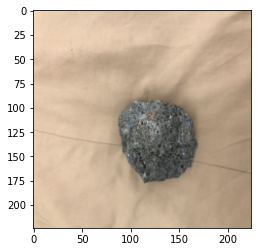

In [113]:
imshow(transformed_img.to("cpu").view((3,224,224)))

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.25, 0.25, 0.25])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated